In [18]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
%autoreload 2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mintpy.utils import readfile, utils as ut 
import h5py
from datetime import datetime

import datetime as dtt
from mintpy.objects import timeseries
from mintpy.utils import time_func, readfile, utils as ut
from mintpy.dem_error import read_exclude_date, read_geometry
from scipy import linalg
from minopy.simulation import simulate_noise
from minopy.lib.utils import est_corr_py
from scipy.linalg import lapack as lap
from scipy.linalg import pinv, pinv2
import minopy.find_short_baselines as fb
from scipy.spatial import Delaunay
from mintpy.utils import ptime
import datetime as dt
import matplotlib.dates as mdates
import random
out_dir = './out_figures'

In [20]:
ts_file = '/Users/Sara/Library/CloudStorage/OneDrive-UniversityofMiami/Miami_final/srtm_2/timeseries.h5'
geom_file = '/Users/Sara/Library/CloudStorage/OneDrive-UniversityofMiami/Miami_final/srtm_2/geometryRadar.h5'

out_dir = './out_figures'

# Sentinel

ts_obj = timeseries(ts_file)

date_list = ts_obj.get_date_list()
indx1 = date_list.index('20180108')
indx2 = date_list.index('20191229')
date_list = date_list[indx1:indx2]

metadata = ts_obj.get_metadata()
sin_inc_angle, range_dist, pbase = read_geometry(ts_file, geom_file, box=None)

pbase = pbase[indx1:indx2]

wavelength = np.float(metadata['radarWavelength'])
seconds = metadata.get('CENTER_LINE_UTC', 0)
tbase = np.array(ptime.date_list2tbase(date_list)[0], np.float32) / 365.25
tbase_diff = np.diff(tbase).reshape(-1, 1)

open geometry file: geometryRadar.h5
read 2D incidenceAngle, slantRangeDistance from geometry file: geometryRadar.h5
read mean bperp from timeseries file


In [21]:
def get_design_matrix4timeseries(date12_list, refDate=None, alpha=0.2):
    """Return design matrix of the input ifgramStack for timeseries estimation
    Parameters: date12_list - list of string in YYYYMMDD_YYYYMMDD format
                refDate     - str, date in YYYYMMDD format
                              set to None for the 1st date
                              set to 'no' to disable reference date
    Returns:    A - 2D array of float32 in size of (num_ifgram, num_date-1)
                B - 2D array of float32 in size of (num_ifgram, num_date-1)
    Examples:   obj = ifgramStack('./inputs/ifgramStack.h5')
                A, B = obj.get_design_matrix4timeseries(obj.get_date12_list(dropIfgram=True))
                A = ifgramStack.get_design_matrix4timeseries(date12_list, refDate='20101022')[0]
                A = ifgramStack.get_design_matrix4timeseries(date12_list, refDate=0)[0] #do not omit the 1st column
    """
    # Date info
    date12_list = list(date12_list)
    date1s = [i.split('_')[0] for i in date12_list]
    date2s = [i.split('_')[1] for i in date12_list]
    date_list = sorted(list(set(date1s + date2s)))
    num_ifgram = len(date12_list)
    num_date = len(date_list)

    # tbase in the unit of years
    date_format = ptime.get_date_str_format(date_list[0])
    dates = np.array([dt.datetime.strptime(i, date_format) for i in date_list])
    tbase = [i.days + i.seconds / (24 * 60 * 60) for i in (dates - dates[0])]
    tbase = np.array(tbase, dtype=np.float32) / 365.25

    # calculate design matrix
    # A for minimizing the residual of phase
    # B for minimizing the residual of phase velocity
    A = np.zeros((num_ifgram, num_date), np.float32)
    B = np.zeros((num_ifgram, num_date), np.float32)
    Alpha = np.zeros((num_ifgram, num_date), np.float32)
    for i in range(num_ifgram):
        ind1, ind2 = [date_list.index(d) for d in date12_list[i].split('_')]
        A[i, ind1] = -1
        A[i, ind2] = 1
        # support date12_list with the first date NOT being the earlier date
        if ind1 < ind2:
            B[i, ind1:ind2] = tbase[ind1 + 1:ind2 + 1] - tbase[ind1:ind2]
            Alpha[i, ind2] = -alpha
            Alpha[i, ind2 - 1] = alpha
        else:
            B[i, ind2:ind1] = tbase[ind2:ind1] - tbase[ind2 + 1:ind1 + 1]
            Alpha[i, ind1] = -alpha
            Alpha[i, ind1 - 1] = alpha
    
    # Remove reference date as it can not be resolved
    if refDate != 'no':
        # default refDate
        if refDate is None:
            # for single   reference network, use the same reference date
            # for multiple reference network, use the first date
            if len(set(date1s)) == 1:
                refDate = date1s[0]
            else:
                refDate = date_list[0]

        # apply refDate
        if refDate:
            ind_r = date_list.index(refDate)
            A = np.hstack((A[:, 0:ind_r], A[:, (ind_r+1):]))
            B = B[:, :-1]
            Alpha = Alpha[:, 0:-1]

    return A, B, Alpha


In [22]:
def simulate_vel_phase(t, linear=False):
    if linear:
        x = t * 0
    else:
        nl = int(len(t) / 4)
        x = np.zeros(len(t))
        x[0:nl] = -2*t[0:nl] 
        x[nl:2 * nl] = 2 * (np.log((t[nl:2 * nl] - t[nl - 1]))) - 3 * (np.log((t[nl] - t[nl - 1])))
        x[2 * nl:3 * nl] = 7 * t[2 * nl:3 * nl] - x[2 * nl - 1] / 2
        x[3 * nl::] = -2 * t[3 * nl::] 
        x = x/10
        x = x * 0.04
    return x

disp_lin = simulate_vel_phase(tbase, linear=True)
disp_vol = simulate_vel_phase(tbase, linear=False)

In [23]:
def delaunay_pairs(date_list, pbase, tbase, disp, wavelength, baseline_ratio=1, plot=False, annual=False):    
    min_baselines = min(pbase)
    max_baselines = max(pbase)
    
    days = [(datetime.strptime(date, '%Y%m%d') - datetime.strptime(date_list[0], '%Y%m%d')).days for date in date_list]

    temp2perp_scale = np.abs((max_baselines - min_baselines) / (np.nanmin(np.array(days)) - np.nanmax(np.array(days))))
    days = [tbase * temp2perp_scale for tbase in days]
    
    t_threshold = 180 * temp2perp_scale
    multplier = np.sqrt(baseline_ratio)
    days = [x / multplier for x in days]
    
    p_threshold = 400
    
    pairtr = []
    for i, date in enumerate(date_list):
        pairtr.append([days[i], pbase[i,0] * multplier])
    #import pdb; pdb.set_trace()
    pairtr = np.array(pairtr)
    tri = Delaunay(pairtr, incremental=False)

    qm = np.zeros([len(date_list), len(date_list)])
    
    for trp in pairtr[tri.simplices]:
        x1 = trp[0][0]
        x2 = trp[1][0]
        x3 = trp[2][0]
        b1 = trp[0][1]
        b2 = trp[1][1]
        b3 = trp[2][1]
        if np.abs(x1 - x2) <= t_threshold:
            qm[days.index(x1), days.index(x2)] = np.abs(b1 - b2)
            qm[days.index(x2), days.index(x1)] = np.abs(b1 - b2)
        if np.abs(x2 - x3) <= t_threshold:
            qm[days.index(x2), days.index(x3)] = np.abs(b2 - b3)
            qm[days.index(x3), days.index(x2)] = np.abs(b2 - b3)
        if np.abs(x1 - x3) <= t_threshold:
            qm[days.index(x1), days.index(x3)] = np.abs(b1 - b3)
            qm[days.index(x3), days.index(x1)] = np.abs(b1 - b3)

    qm[qm > p_threshold] = 0
    
    for i in range(len(date_list)):
        if len(np.nonzero(qm[i, :])[0]) <= 1:
            qm[i, :] = 0
            
    A = np.triu(qm)
    ind1, ind2 = np.where(A > 0)
    ifgdates = ['{}_{}'.format(date_list[g], date_list[h]) for g, h in zip(ind1, ind2)]
    
    if annual:
        annual_pairs, ind11, ind22 = find_one_year_interferograms(date_list)
        ifgdates += annual_pairs
        ind1 = list(ind1) + list(ind11)
        ind2 = list(ind2) + list(ind22)
        
    
    ifg_values = []
    for i,j in zip(ind1, ind2):
        disp_ifg = (disp[i]-disp[j])
        ifg_values.append(disp_ifg*4*np.pi/wavelength)
    
    #fb.plot_baselines(ind1=ind1, ind2=ind2, dates=dates, baselines=baselines,
    #               out_dir=os.path.dirname(inps.out_file))
    if plot:
        plot_baselines(ind1, ind2, date_list, pbase) 
        
    ref_date = None
    return ifg_values, ifgdates, ref_date


def find_short_pbaseline_pair(baselines, date_list, ministack_size, last_index):

    second_index = np.arange(last_index - ministack_size + 1, last_index)
    diff_bselines = [np.abs(baselines[last_index - ministack_size - 2] - baselines[i]) for i in second_index]
    min_ind = np.min(diff_bselines)
    pair = (date_list[last_index - ministack_size - 2], date_list[second_index[diff_bselines.index(min_ind)]])
    
    return pair

def mini_stack_pairs(date_list, pbase,tbase, disp, wavelength, plot=False, annual=False):
    month = 6
    pairs=[]
    dates = [datetime.strptime(date_str, '%Y%m%d') for date_str in date_list]
    years = np.array([x.year for x in dates])
    u, indices_first = np.unique(years, return_index=True)
    f_ind = indices_first
    l_ind = np.zeros(indices_first.shape, dtype=np.int)
    l_ind[0:-1] = np.array(f_ind[1::]).astype(np.int)
    l_ind[-1] = len(dates)
    ref_inds = []
    for i in range(len(f_ind)):
        months = np.array([x.month for x in dates[f_ind[i]:l_ind[i]]])
        u, indices = np.unique(months, return_index=True)
        ind = np.where(u == month)[0]
        if len(ind) == 0:
            ind = int(len(u)//2)
        else:
            ind = ind[0]
        ref_ind = indices[ind] + f_ind[i]
        ref_inds.append(ref_ind)

        for k in range(f_ind[i], l_ind[i]):
            pairs.append((date_list[ref_ind], date_list[k]))
        ministack_size = l_ind[i] - f_ind[i]
        if i > 0:
            pairs.append(find_short_pbaseline_pair(pbase, date_list, ministack_size, l_ind[i]))
            
    for i in range(len(ref_inds)-1):
        pairs.append((date_list[ref_inds[i]], date_list[ref_inds[i+1]]))
        pairs.append((date_list[l_ind[i]-1], date_list[l_ind[i]]))
    
    ind1=[]
    ind2=[]
    
    
    
    for pair in pairs:
        ind1.append(date_list.index(pair[0]))
        ind2.append(date_list.index(pair[1]))
    
    ifgdates = ['{}_{}'.format(date_list[g], date_list[h]) for g, h in zip(ind1, ind2)]
    if annual:
        annual_pairs, ind11, ind22 = find_one_year_interferograms(date_list)
        ifgdates += annual_pairs
        ind1 = list(ind1) + list(ind11)
        ind2 = list(ind2) + list(ind22)
    
    ifg_values = []
    for i,j in zip(ind1, ind2):
        disp_ifg = (disp[i]-disp[j])
        ifg_values.append(disp_ifg*4*np.pi/wavelength)
        
    if plot:
        plot_baselines(ind1, ind2, date_list, pbase) 
    
    ref_date = None
    return ifg_values, ifgdates, ref_date



def sequential_pairs(date_list, pbase,tbase, disp, wavelength, num_seq=2, plot=False, annual=False):
    pairs=[]
    for t in range(0, num_seq-1):
        for l in range(t + 1, num_seq):
            pairs.append((date_list[t], date_list[l]))
    for i in range(num_seq, len(date_list)):
        for t in range(1, num_seq + 1):
            pairs.append((date_list[i - t], date_list[i]))
            
    ind1=[]
    ind2=[]
    for pair in pairs:
        ind1.append(date_list.index(pair[0]))
        ind2.append(date_list.index(pair[1]))
        
    ifgdates = ['{}_{}'.format(date_list[g], date_list[h]) for g, h in zip(ind1, ind2)]
    if annual:
        annual_pairs, ind11, ind22 = find_one_year_interferograms(date_list)
        ifgdates += annual_pairs
        ind1 = list(ind1) + list(ind11)
        ind2 = list(ind2) + list(ind22)
        
    ifg_values = []
    for i,j in zip(ind1, ind2):
        disp_ifg = (disp[i]-disp[j])
        ifg_values.append(disp_ifg*4*np.pi/wavelength)
        
    if plot:
        plot_baselines(ind1, ind2, date_list, pbase) 
        
    ref_date = None
    return ifg_values, ifgdates, ref_date



def single_reference_pairs(date_list, pbase,tbase, disp, wavelength, plot=False, annual=False):
    pairs=[]
    indx = int(len(date_list) // 2)
    reference_date = date_list[indx]
    for i in range(0, len(date_list)):
        if not indx == i:
            pairs.append((date_list[indx], date_list[i]))
    
    ind1=[]
    ind2=[]
    for pair in pairs:
        ind1.append(date_list.index(pair[0]))
        ind2.append(date_list.index(pair[1]))
        
    ifgdates = ['{}_{}'.format(date_list[g], date_list[h]) for g, h in zip(ind1, ind2)]
    if annual:
        annual_pairs, ind11, ind22 = find_one_year_interferograms(date_list)
        ifgdates += annual_pairs
        ind1 = list(ind1) + list(ind11)
        ind2 = list(ind2) + list(ind22)
        
    ifg_values = []
    for i,j in zip(ind1, ind2):
        disp_ifg = (disp[i]-disp[j])
        ifg_values.append(disp_ifg*4*np.pi/wavelength)
        
        
    if plot:
        plot_baselines(ind1, ind2, date_list, pbase) 
        
   
    return ifg_values, ifgdates, reference_date


def find_one_year_interferograms(date_list):
    dates = np.array([dtt.datetime.strptime(date, '%Y%m%d') for date in date_list])

    #ifg_ind = []
    ind1 = []
    ind2 = []
    for i, date in enumerate(dates):
        range_1 = date + dtt.timedelta(days=365) - dtt.timedelta(days=5)
        range_2 = date + dtt.timedelta(days=365) + dtt.timedelta(days=5)
        index = np.where((dates >= range_1) * (dates <= range_2))[0]
        if len(index) >= 1:
            date_diff = list(dates[index] - (date + dtt.timedelta(days=365)))
            ind = date_diff.index(np.nanmin(date_diff))
            ind_date = index[ind]
            ind1.append(i)
            ind2.append(ind_date)
            #date2 = date_list[ind_date]
            #ifg_ind.append((date_list[i], date2))
            
    ifgdates = ['{}_{}'.format(date_list[g], date_list[h]) for g, h in zip(ind1, ind2)]

    return ifgdates, ind1, ind2


def plot_baselines(ind1, ind2, dates, pbase):
    years = mdates.YearLocator()
    months = mdates.MonthLocator()
    years_fmt = mdates.DateFormatter('%Y')
    
    ifgdates = ['{}_{}, {}, {}, {}\n'.format(dates[g], dates[h], str(pbase[g,0]),
                                             str(pbase[h,0]), str(pbase[g,0] - pbase[h,0]))
                for g, h in zip(ind1, ind2)]
    
    fig = plt.figure(figsize=(8, 4))
    
    for d in ifgdates:
        X = d.split(',')[0].split('_')
        x1 = datetime.strptime(X[0], '%Y%m%d')
        x2 = datetime.strptime(X[1], '%Y%m%d')

        Y = d.split('\n')[0].split(',')[1:3]
    
        y1 = float(Y[0])
        y2 = float(Y[1])
        plt.plot([x1, x2], [y1, y2], 'ko-', markersize=10)
        
    plt.xlabel('Time [years]')
    plt.ylabel('Perp Baseline [m]')
    
    
    ax = plt.gca()
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(months)
    ax.autoscale_view()
    plt.show()
    
    return



    

In [7]:
def invert_timeseries_L1(date_list, pairs, ifg_values, ref_date, percentage=10, repeat=1, wavelength=0.056, noise_range=1, sign='random'):
    rcond=1e-5
    model = dict()
    model['polynomial'] = 1
    model['periodic']   = []
    model['step']       = []
    model['exp']        = dict()
    model['log']        = dict()
    
    phase2range = -1 * float(wavelength) / (4.*np.pi)
    num_date = len(date_list)
    num_param = 2
    
    ts_data = np.zeros((len(date_list), ))
    ts_data_L2 = np.zeros((len(date_list), ))
    
    d = int(percentage*len(pairs)/100)
        
    xind = random.sample(range(0, len(pairs)), d)
        
    noise = np.empty((d,))
    if sign == 'random':
        if d == 1:
            noise[1] = 6*np.pi
        else:
            indm = d//2
            noise[0:indm] = 6*np.pi
            noise[indm::] = -8*np.pi
    elif sign == 'positive':
        noise[:] = 6*np.pi
    else:
        noise[:] = -8*np.pi
        
            
    ifg = np.zeros(np.array(ifg_values).shape)
    ifg[:] = np.array(ifg_values)[:] 
    ifg[xind] += noise

    A, B, Alpha = get_design_matrix4timeseries(pairs, refDate=ref_date, alpha=0.01)
    X_L2, e2_L2 = linalg.lstsq(B, ifg, cond=rcond)[:2]
    
    ifg2 = np.zeros(ifg.shape)
    ifg = np.concatenate([ifg, ifg2]).flatten()
    print(Alpha.shape, B.shape)
    B = np.concatenate([B, Alpha])
    
        
    W = np.eye((ifg.shape[0]))
    inv_Q = pinv2(np.matmul(np.matmul(np.transpose(B),W),B))
    Coef = np.matmul(np.matmul(np.transpose(B),W),ifg)
    X = np.matmul(inv_Q, Coef)
    
    res = np.abs(ifg - np.matmul(B,X))
    res[res<1e-7] = 1e-7
    max1 = np.empty(res.shape)
    max2 = np.empty(res.shape)
    max1[:] = res[:]
    max2[:] = 1
    diff_res = np.max(np.abs(max1 - max2))
    ii = 0
    while diff_res > 1e-8:   
        W = np.diag(1./res.flatten())
        W = W/np.max(W)
        inv_Q = pinv2(np.matmul(np.matmul(np.transpose(B),W),B))
        Coef = np.matmul(np.matmul(np.transpose(B),W),ifg)
        X = np.matmul(inv_Q, Coef)
        res = np.abs(ifg - np.matmul(B,X))
        res[res<1e-7] = 1e-7
        max2[:] = res[:]
        diff_res = np.max(np.abs(max1 - max2))
        ii += 1
        if ii > 5:
            break
        max1[:] = max2[:]

    print('{} iteration for L1'.format(ii))
    ts_diff = X.reshape(-1,1) * tbase_diff
    ts_data[1:] = np.cumsum(ts_diff.flatten(), axis=0)
    ts_data[1:,] *= phase2range
    
    ts_diff_L2 = X_L2.reshape(-1,1) * tbase_diff
    ts_data_L2[1:] = np.cumsum(ts_diff_L2.flatten(), axis=0)
    ts_data_L2[1:,] *= phase2range
    
    
    return ts_data, ts_data_L2


def plot_unwrap_error(ts_data_l1, ts_date_l2, disp, tbase, name=None, title=None, legend=None, out_dir=None, ylim = [-4,4]):
    plt.rcParams["font.size"] = "18"
    years = mdates.YearLocator()
    years_fmt = mdates.DateFormatter('%Y')
    months = mdates.MonthLocator()
    xx= [datetime.strptime(i, '%Y%m%d') for i in date_list]

    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 3))

    axs.plot(xx, ts_data_l1*100, '.', markersize=12, color='r')
    axs.plot(xx, ts_data_l2*100, '.', markersize=16, markerfacecolor=(0,0,0,0), markeredgecolor='b')
    axs.plot(xx, disp*100, 'k')

    plt.legend(['L1', 'L2', 'No unw err'], bbox_to_anchor=(1,1))
    axs.set_title(title)
    axs.set_ylabel("Displacement [cm]")
    axs.set_xlabel("Time [Year]")
    axs.set_ylim(ylim)
    #axs.set_ylim([-1,1])

    ax = plt.gca()
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(months)
    plt.savefig(out_dir +'/dot_{}_{}.png'.format(name, title), bbox_inches='tight', dpi=300) 
    return



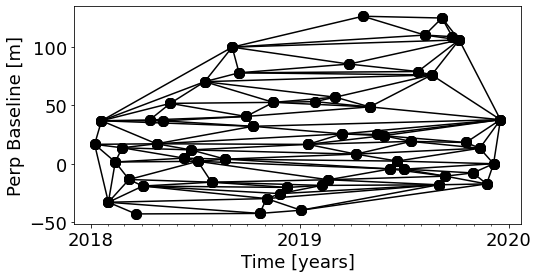

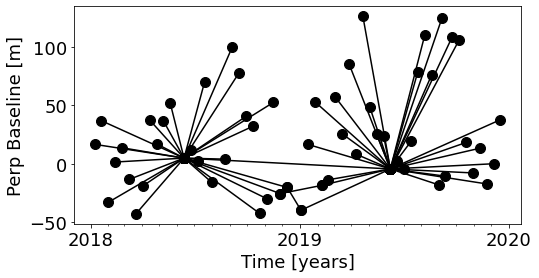

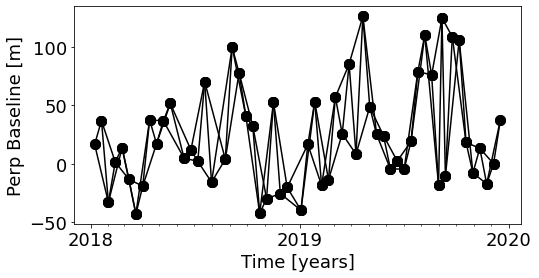

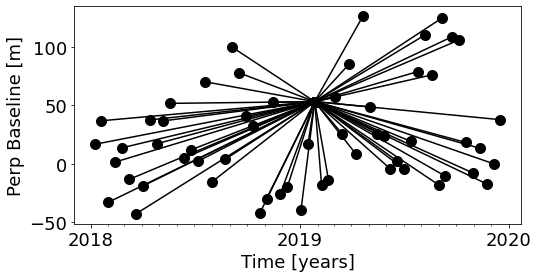

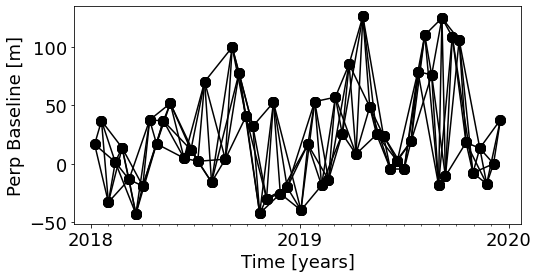

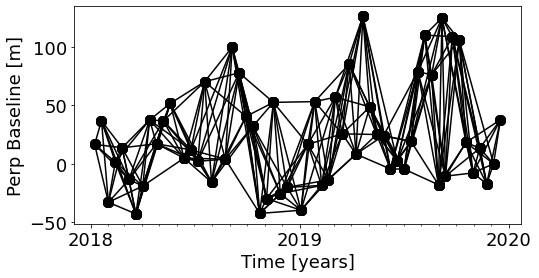

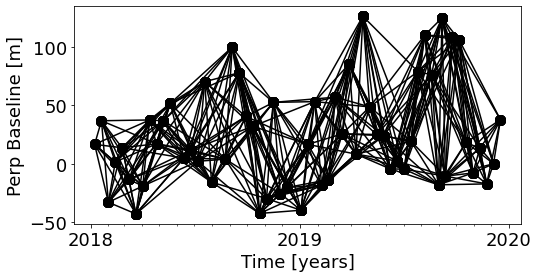

In [27]:
# linear

ifg_values_de, pairs_de, ref_date_de = delaunay_pairs(date_list, pbase, tbase, disp_lin, wavelength, baseline_ratio=6, plot=True)
ifg_values_mi, pairs_mi, ref_date_mi = mini_stack_pairs(date_list, pbase, tbase, disp_lin, wavelength, plot=True)
ifg_values_se, pairs_se, ref_date_se = sequential_pairs(date_list, pbase, tbase, disp_lin, wavelength, num_seq=2, plot=True)
ifg_values_si, pairs_si, ref_date_si = single_reference_pairs(date_list, pbase, tbase, disp_lin, wavelength, plot=True)
ifg_values_se3, pairs_se3, ref_date_se3 = sequential_pairs(date_list, pbase, tbase, disp_lin, wavelength, num_seq=3, plot=True)
ifg_values_se5, pairs_se5, ref_date_se5 = sequential_pairs(date_list, pbase, tbase, disp_lin, wavelength, num_seq=5, plot=True)
ifg_values_se8, pairs_se8, ref_date_se8 = sequential_pairs(date_list, pbase, tbase, disp_lin, wavelength, num_seq=8, plot=True)

# volcanic

vifg_values_de, vpairs_de, ref_date_de = delaunay_pairs(date_list, pbase, tbase, disp_vol, wavelength, baseline_ratio=6, plot=False)
vifg_values_mi, vpairs_mi, ref_date_mi = mini_stack_pairs(date_list, pbase, tbase, disp_vol, wavelength, plot=False)
vifg_values_se, vpairs_se, ref_date_se = sequential_pairs(date_list, pbase, tbase, disp_vol, wavelength, num_seq=2, plot=False)
vifg_values_si, vpairs_si, ref_date_si = single_reference_pairs(date_list, pbase, tbase, disp_vol, wavelength, plot=False)
vifg_values_se3, vpairs_se3, ref_date_se3 = sequential_pairs(date_list, pbase, tbase, disp_vol, wavelength, num_seq=3, plot=False)
vifg_values_se5, vpairs_se5, ref_date_se5 = sequential_pairs(date_list, pbase, tbase, disp_vol, wavelength, num_seq=5, plot=False)
vifg_values_se8, vpairs_se8, ref_date_se8 = sequential_pairs(date_list, pbase, tbase, disp_vol, wavelength, num_seq=8, plot=False)



(157, 57) (157, 57)
6 iteration for L1


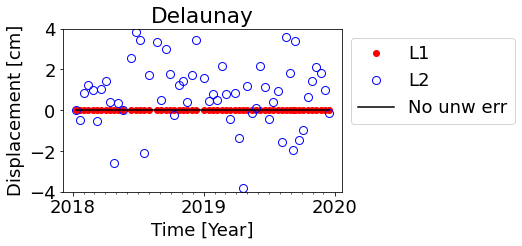

In [9]:
ts_data_l1, ts_data_l2 = invert_timeseries_L1(date_list, pairs_de, ifg_values_de, ref_date_de, 
                               percentage=10, repeat=1, 
                               wavelength=0.056, noise_range=1, sign='random')

plot_unwrap_error(ts_data_l1, ts_data_l2, disp_lin, tbase, name='test_L1', title='Delaunay', legend=None, out_dir='./out_figures', ylim = [-4,4])

(157, 57) (157, 57)
6 iteration for L1


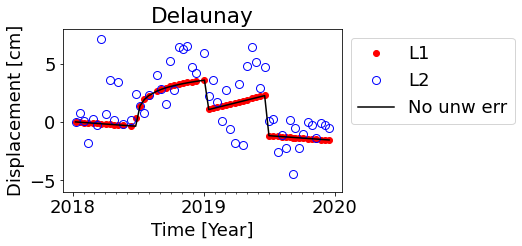

In [10]:
ts_data_l1, ts_data_l2 = invert_timeseries_L1(date_list, vpairs_de, vifg_values_de, ref_date_de, 
                               percentage=10, repeat=1, 
                               wavelength=0.056, noise_range=1, sign='random')

plot_unwrap_error(ts_data_l1, ts_data_l2, disp_vol, tbase, name='test_vol_L1', title='Delaunay', legend=None, out_dir='./out_figures', ylim = [-6,8])

(57, 57) (57, 57)
6 iteration for L1


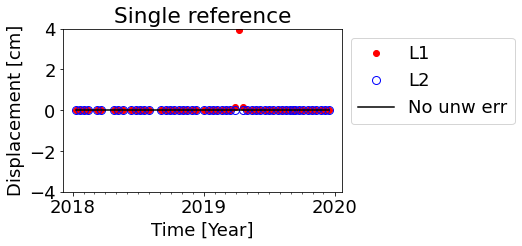

In [11]:
ts_data_l1, ts_data_l2 = invert_timeseries_L1(date_list, pairs_si, ifg_values_si, ref_date_si, 
                               percentage=10, repeat=1, 
                               wavelength=0.056, noise_range=1, sign='random')

plot_unwrap_error(ts_data_l1, ts_data_l2, disp_lin, tbase, name='test_L1', title='Single reference', legend=['L1', 'no unwrap err'], out_dir='./out_figures', ylim = [-4,4])

(57, 57) (57, 57)
6 iteration for L1


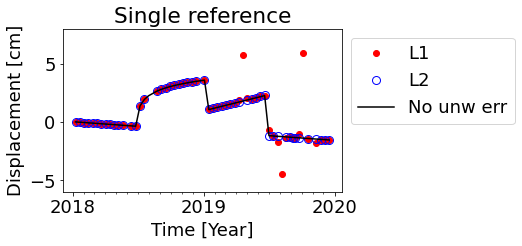

In [12]:
ts_data_l1, ts_data_l2 = invert_timeseries_L1(date_list, vpairs_si, vifg_values_si, ref_date_si, 
                               percentage=10, repeat=1, 
                               wavelength=0.056, noise_range=1, sign='random')

plot_unwrap_error(ts_data_l1, ts_data_l2, disp_vol, tbase, name='test_vol_L1', title='Single reference', legend=['L1', 'no unwrap err'], out_dir='./out_figures', ylim = [-6,8])

(61, 57) (61, 57)
92 iteration for L1


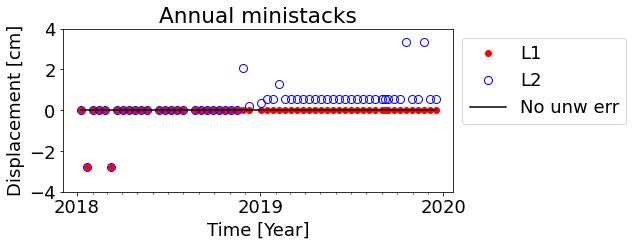

In [695]:
ts_data_l1, ts_data_l2 = invert_timeseries_L1(date_list, pairs_mi, ifg_values_mi, ref_date_mi, 
                               percentage=10, repeat=1, 
                               wavelength=0.056, noise_range=1, sign='random')

plot_unwrap_error(ts_data_l1, ts_data_l2, disp_lin, tbase, name='test_L1', title='Annual ministacks', legend=['L1', 'no unwrap err'], out_dir='./out_figures', ylim = [-4,4])

(61, 57) (61, 57)
93 iteration for L1


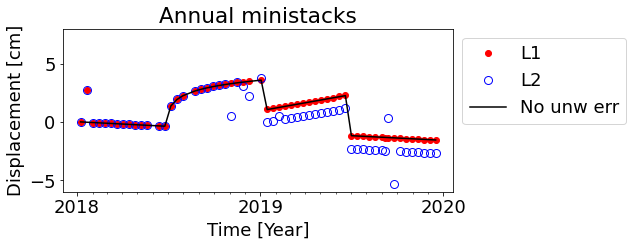

In [699]:
ts_data_l1, ts_data_l2 = invert_timeseries_L1(date_list, vpairs_mi, vifg_values_mi, ref_date_mi, 
                               percentage=10, repeat=1, 
                               wavelength=0.056, noise_range=1, sign='random')

plot_unwrap_error(ts_data_l1, ts_data_l2, disp_vol, tbase, name='test_vol_L1', title='Annual ministacks', legend=['L1', 'no unwrap err'], out_dir='./out_figures', ylim = [-6,8])

(113, 57) (113, 57)
70 iteration for L1


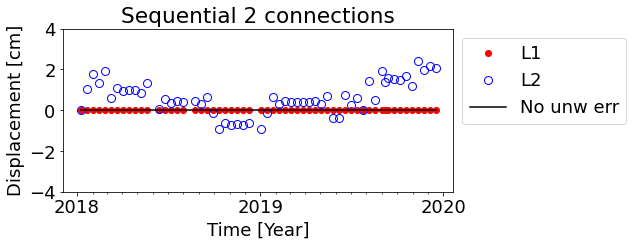

In [700]:
ts_data_l1, ts_data_l2 = invert_timeseries_L1(date_list, pairs_se, ifg_values_se, ref_date_se, 
                               percentage=10, repeat=1, 
                               wavelength=0.056, noise_range=1, sign='random')

plot_unwrap_error(ts_data_l1, ts_data_l2, disp_lin, tbase, name='test_L1', title='Sequential 2 connections', legend=['L1', 'no unwrap err'], out_dir='./out_figures', ylim = [-4,4])

(113, 57) (113, 57)
38 iteration for L1


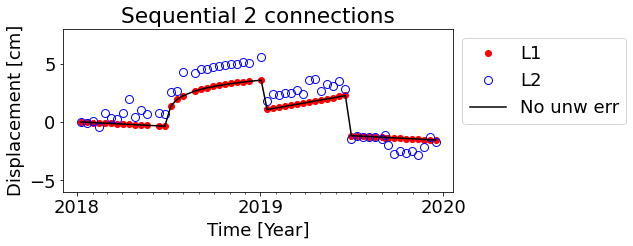

In [701]:
ts_data_l1, ts_data_l2 = invert_timeseries_L1(date_list, vpairs_se, vifg_values_se, ref_date_se, 
                               percentage=10, repeat=1, 
                               wavelength=0.056, noise_range=1, sign='random')

plot_unwrap_error(ts_data_l1, ts_data_l2, disp_vol, tbase, name='test_vol_L1', title='Sequential 2 connections', legend=['L1', 'no unwrap err'], out_dir='./out_figures', ylim = [-6,8])

(168, 57) (168, 57)
31 iteration for L1


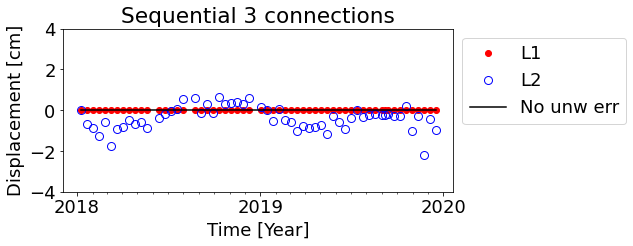

In [702]:
ts_data_l1, ts_data_l2 = invert_timeseries_L1(date_list, pairs_se3, ifg_values_se3, ref_date_se3, 
                               percentage=10, repeat=1, 
                               wavelength=0.056, noise_range=1, sign='random')

plot_unwrap_error(ts_data_l1, ts_data_l2, disp_lin, tbase, name='test_L1', title='Sequential 3 connections', legend=['L1', 'no unwrap err'], out_dir='./out_figures', ylim = [-4,4])

(168, 57) (168, 57)
25 iteration for L1


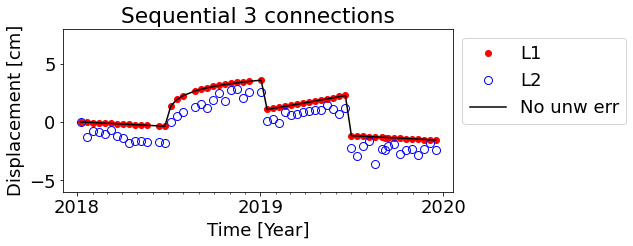

In [703]:
ts_data_l1, ts_data_l2 = invert_timeseries_L1(date_list, vpairs_se3, vifg_values_se3, ref_date_se3, 
                               percentage=10, repeat=1, 
                               wavelength=0.056, noise_range=1, sign='random')

plot_unwrap_error(ts_data_l1, ts_data_l2, disp_vol, tbase, name='test_vol_L1', title='Sequential 3 connections', legend=['L1', 'no unwrap err'], out_dir='./out_figures', ylim = [-6,8])

(275, 57) (275, 57)
37 iteration for L1


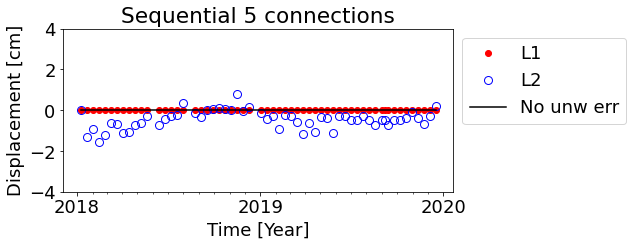

In [704]:
ts_data_l1, ts_data_l2 = invert_timeseries_L1(date_list, pairs_se5, ifg_values_se5, ref_date_se5, 
                               percentage=10, repeat=1, 
                               wavelength=0.056, noise_range=1, sign='random')

plot_unwrap_error(ts_data_l1, ts_data_l2, disp_lin, tbase, name='test_L1', title='Sequential 5 connections', legend=['L1', 'no unwrap err'], out_dir='./out_figures', ylim = [-4,4])

(275, 57) (275, 57)
48 iteration for L1


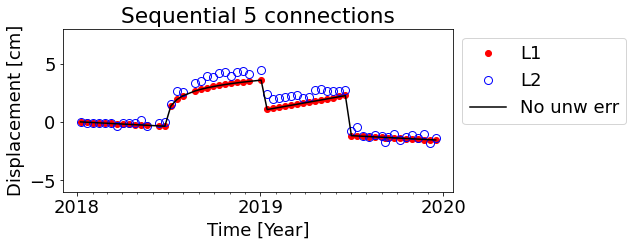

In [705]:
ts_data_l1, ts_data_l2 = invert_timeseries_L1(date_list, vpairs_se5, vifg_values_se5, ref_date_se5, 
                               percentage=10, repeat=1, 
                               wavelength=0.056, noise_range=1, sign='random')

plot_unwrap_error(ts_data_l1, ts_data_l2, disp_vol, tbase, name='test_vol_L1', title='Sequential 5 connections', legend=['L1', 'no unwrap err'], out_dir='./out_figures', ylim = [-6,8])

(428, 57) (428, 57)
14 iteration for L1


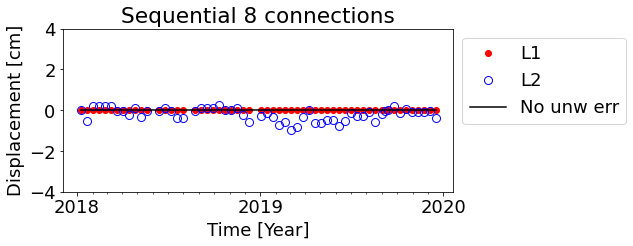

In [706]:
ts_data_l1, ts_data_l2 = invert_timeseries_L1(date_list, pairs_se8, ifg_values_se8, ref_date_se8, 
                               percentage=10, repeat=1, 
                               wavelength=0.056, noise_range=1, sign='random')

plot_unwrap_error(ts_data_l1, ts_data_l2, disp_lin, tbase, name='test_L1', title='Sequential 8 connections', legend=['L1', 'no unwrap err'], out_dir='./out_figures', ylim = [-4,4])

(428, 57) (428, 57)
32 iteration for L1


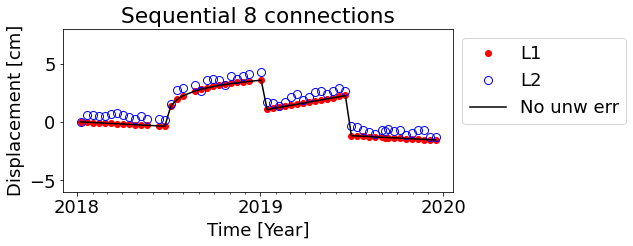

In [707]:
ts_data_l1, ts_data_l2 = invert_timeseries_L1(date_list, vpairs_se8, vifg_values_se8, ref_date_se8, 
                               percentage=10, repeat=1, 
                               wavelength=0.056, noise_range=1, sign='random')

plot_unwrap_error(ts_data_l1, ts_data_l2, disp_vol, tbase, name='test_vol_L1', title='Sequential 8 connections', legend=['L1', 'no unwrap err'], out_dir='./out_figures', ylim = [-6,8])

In [13]:
def invert_timeseries_L1_seasonal(date_list, pairs, ifg_values, ref_date, percentage=10, repeat=1, wavelength=0.056, noise_range=1, sign='random'):
    rcond=1e-5
    model = dict()
    model['polynomial'] = 1
    model['periodic']   = []
    model['step']       = []
    model['exp']        = dict()
    model['log']        = dict()
    
    phase2range = -1 * float(wavelength) / (4.*np.pi)
    num_date = len(date_list)
    num_param = 2
    
    ts_data = np.zeros((len(date_list), ))
    ts_data_L2 = np.zeros((len(date_list), ))
    
    tt = [pair.split('_')[1] for pair in pairs]
    tt1 = np.array([datetime.strptime(im, '%Y%m%d').month for im in tt])
    tt2 = list(np.sort(np.concatenate((np.where(tt1==10)[0], np.where(tt1==11)[0], np.where(tt1==12)[0]))))
    
    d = len(tt2) #int(percentage[i]*len(pairs)/100)
        
    xind = random.sample(tt2, d)
    nn = 8
        
    noise = np.empty((d,))
    if sign == 'random':
        if d == 1:
            noise[1] = nn*np.pi
        else:
            indm = d//2
            noise[0:indm] = nn*np.pi
            noise[indm::] = -nn*np.pi
    elif sign == 'positive':
        noise[:] = nn*np.pi
    else:
        noise[:] = -nn*np.pi
        
            
    ifg = np.zeros(np.array(ifg_values).shape).reshape(-1,1)
    ifg[:,0] = np.array(ifg_values)[:] 
    ifg[xind,0] += noise
    
    A, B, Alpha = get_design_matrix4timeseries(pairs, refDate=ref_date, alpha=0.001)
    X_L2, e2_L2 = linalg.lstsq(B, ifg, cond=rcond)[:2]
    
    ifg2 = np.zeros(ifg.shape)
    ifg = np.concatenate([ifg, ifg2]).flatten()
    B = np.concatenate([B, Alpha])
    W = np.eye((ifg.shape[0]))
    inv_Q = pinv(np.linalg.multi_dot([B.T, W, B]))
    Coef = np.linalg.multi_dot([B.T, W, ifg])
    X = np.matmul(inv_Q, Coef)
    
    res = np.abs(ifg - np.matmul(B,X))
    res[res<1e-6] = 1e-6
    max1 = np.empty(res.shape)
    max2 = np.empty(res.shape)
    max1[:] = res[:]
    max2[:] = 1
    diff_res = np.max(np.abs(max1 - max2))
    ii = 0
    max_iter = 100
    for ii in range(max_iter):
        if diff_res < 1e-2:   
            break
        W = np.diag(1./res.flatten())
        W = W/np.max(W)
        inv_Q = pinv(np.linalg.multi_dot([B.T, W, B]))
        Coef = np.linalg.multi_dot([B.T, W, ifg])
        X = np.matmul(inv_Q, Coef)
        res = np.abs(ifg - np.matmul(B,X))
        res[res<1e-6] = 1e-6
        max2[:] = res[:]
        diff_res = np.max(np.abs(max1 - max2))
        ii += 1
        max1[:] = max2[:]
    print('{} iteration for L1'.format(ii))
    ts_diff = X.reshape(-1,1) * tbase_diff
    ts_data[1:] = np.cumsum(ts_diff.flatten(), axis=0)
    ts_data[1:,] *= phase2range
    
    ts_diff_L2 = X_L2.reshape(-1,1) * tbase_diff
    ts_data_L2[1:] = np.cumsum(ts_diff_L2.flatten(), axis=0)
    ts_data_L2[1:,] *= phase2range
    
    
    return ts_data, ts_data_L2

def plot_unwrap_error_seasonal(ts_data_l1, ts_date_l2, sts_data_l1, sts_date_l2, disp, tbase, name=None, title=None, legend=None, out_dir=None, ylim = [-4,4]):
    plt.rcParams["font.size"] = "18"
    years = mdates.YearLocator()
    years_fmt = mdates.DateFormatter('%Y')
    months = mdates.MonthLocator()
    xx= [datetime.strptime(i, '%Y%m%d') for i in date_list]

    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))

    axs.plot(xx, ts_data_l1*100, '.', markersize=12, color='y')
    axs.plot(xx, ts_data_l2*100, '.', markersize=16, markerfacecolor=(0,0,0,0), markeredgecolor='k')
    axs.plot(xx, sts_data_l1*100+5, '.', markersize=12, color='b')
    axs.plot(xx, sts_data_l2*100+5, '.', markersize=16, markerfacecolor=(0,0,0,0), markeredgecolor='r')
    axs.plot(xx, disp*100, 'k')
    axs.plot(xx, disp*100+5, 'k')

    #plt.legend(['L1 random', 'L2 random', 'L1 seasonal', 'L2 seasonal', 'No unw err'], bbox_to_anchor=(1,1))
    axs.set_title(title, fontsize=18)
    axs.set_ylabel("Displacement [cm]")
    axs.set_xlabel("Time [Year]")
    axs.set_ylim(ylim)
    #axs.set_ylim([-1,1])

    ax = plt.gca()
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(months)
    plt.savefig(out_dir +'/dot_{}_{}.png'.format(name, title), bbox_inches='tight', dpi=300) 
    return

(157, 57) (157, 57)
6 iteration for L1
4 iteration for L1


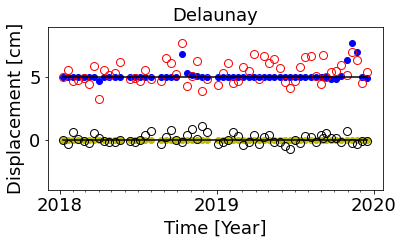

In [940]:
ts_data_l1, ts_data_l2 = invert_timeseries_L1(date_list, pairs_de, ifg_values_de, ref_date_de, 
                               percentage=10, repeat=1, 
                               wavelength=0.056, noise_range=1, sign='random')

sts_data_l1, sts_data_l2 = invert_timeseries_L1_seasonal(date_list, pairs_de, ifg_values_de, ref_date_de, 
                               percentage=10, repeat=1, 
                               wavelength=0.056, noise_range=1, sign='random')

plot_unwrap_error_seasonal(ts_data_l1, ts_data_l2, sts_data_l1, sts_data_l2, disp_lin, tbase, name='2_L1L2', title='Delaunay', legend=None, out_dir='./out_figures', ylim = [-4,9])

(57, 57) (57, 57)
6 iteration for L1
5 iteration for L1


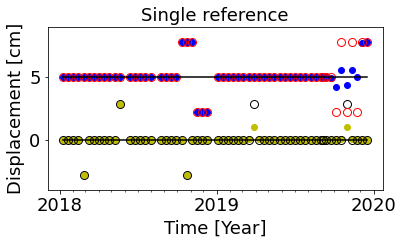

In [941]:
ts_data_l1, ts_data_l2 = invert_timeseries_L1(date_list, pairs_si, ifg_values_si, ref_date_si, 
                               percentage=10, repeat=1, 
                               wavelength=0.056, noise_range=1, sign='random')

sts_data_l1, sts_data_l2 = invert_timeseries_L1_seasonal(date_list, pairs_si, ifg_values_si, ref_date_si, 
                               percentage=10, repeat=1, 
                               wavelength=0.056, noise_range=1, sign='random')

plot_unwrap_error_seasonal(ts_data_l1, ts_data_l2, sts_data_l1, sts_data_l2, disp_lin, tbase, name='2_L1L2', title='Single reference', legend=None, out_dir='./out_figures', ylim = [-4,9])

(61, 57) (61, 57)
6 iteration for L1
4 iteration for L1


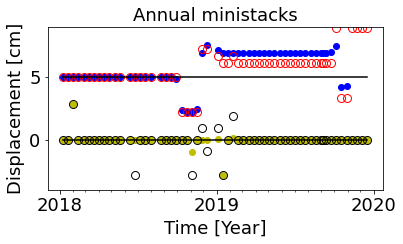

In [942]:
ts_data_l1, ts_data_l2 = invert_timeseries_L1(date_list, pairs_mi, ifg_values_mi, ref_date_mi, 
                               percentage=10, repeat=1, 
                               wavelength=0.056, noise_range=1, sign='random')

sts_data_l1, sts_data_l2 = invert_timeseries_L1_seasonal(date_list, pairs_mi, ifg_values_mi, ref_date_mi, 
                               percentage=10, repeat=1, 
                               wavelength=0.056, noise_range=1, sign='random')

plot_unwrap_error_seasonal(ts_data_l1, ts_data_l2, sts_data_l1, sts_data_l2, disp_lin, tbase, name='2_L1L2', title='Annual ministacks', legend=None, out_dir='./out_figures', ylim = [-4,9])

(168, 57) (168, 57)
6 iteration for L1
6 iteration for L1


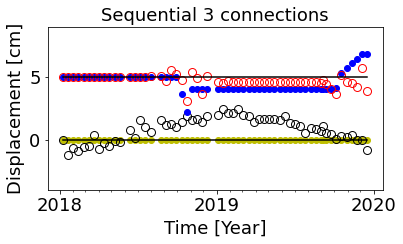

In [943]:
ts_data_l1, ts_data_l2 = invert_timeseries_L1(date_list, pairs_se3, ifg_values_se3, ref_date_se3, 
                               percentage=10, repeat=1, 
                               wavelength=0.056, noise_range=1, sign='random')

sts_data_l1, sts_data_l2 = invert_timeseries_L1_seasonal(date_list, pairs_se3, ifg_values_se3, ref_date_se3, 
                               percentage=10, repeat=1, 
                               wavelength=0.056, noise_range=1, sign='random')

plot_unwrap_error_seasonal(ts_data_l1, ts_data_l2, sts_data_l1, sts_data_l2, disp_lin, tbase, name='2_L1L2', title='Sequential 3 connections', legend=None, out_dir='./out_figures', ylim = [-4,9])

(275, 57) (275, 57)
6 iteration for L1
4 iteration for L1


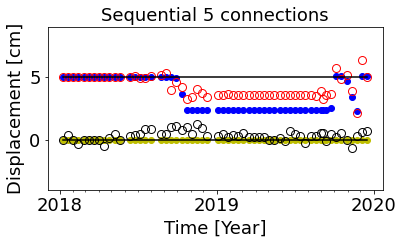

In [944]:
ts_data_l1, ts_data_l2 = invert_timeseries_L1(date_list, pairs_se5, ifg_values_se5, ref_date_se5, 
                               percentage=10, repeat=1, 
                               wavelength=0.056, noise_range=1, sign='random')

sts_data_l1, sts_data_l2 = invert_timeseries_L1_seasonal(date_list, pairs_se5, ifg_values_se5, ref_date_se5, 
                               percentage=10, repeat=1, 
                               wavelength=0.056, noise_range=1, sign='random')

plot_unwrap_error_seasonal(ts_data_l1, ts_data_l2, sts_data_l1, sts_data_l2, disp_lin, tbase, name='2_L1L2', title='Sequential 5 connections', legend=None, out_dir='./out_figures', ylim = [-4,9])

(428, 57) (428, 57)
6 iteration for L1
4 iteration for L1


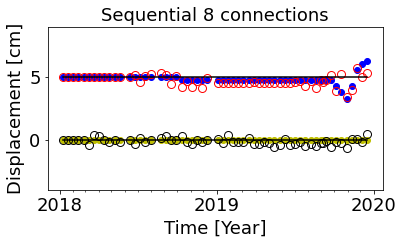

In [945]:
ts_data_l1, ts_data_l2 = invert_timeseries_L1(date_list, pairs_se8, ifg_values_se8, ref_date_se8, 
                               percentage=10, repeat=1, 
                               wavelength=0.056, noise_range=1, sign='random')

sts_data_l1, sts_data_l2 = invert_timeseries_L1_seasonal(date_list, pairs_se8, ifg_values_se8, ref_date_se8, 
                               percentage=10, repeat=1, 
                               wavelength=0.056, noise_range=1, sign='random')

plot_unwrap_error_seasonal(ts_data_l1, ts_data_l2, sts_data_l1, sts_data_l2, disp_lin, tbase, name='2_L1L2', title='Sequential 8 connections', legend=None, out_dir='./out_figures', ylim = [-4,9])

54 iteration for L1


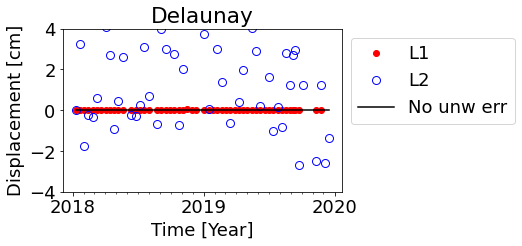

In [16]:
ts_data_l1, ts_data_l2 = invert_timeseries_L1_seasonal(date_list, pairs_de, ifg_values_de, ref_date_de, 
                               percentage=10, repeat=1, 
                               wavelength=0.056, noise_range=1, sign='random')

plot_unwrap_error(ts_data_l1, ts_data_l2, disp_lin, tbase, name='test_seasonal_L1', title='Delaunay', legend=None, out_dir='./out_figures', ylim = [-4,4])

100 iteration for L1


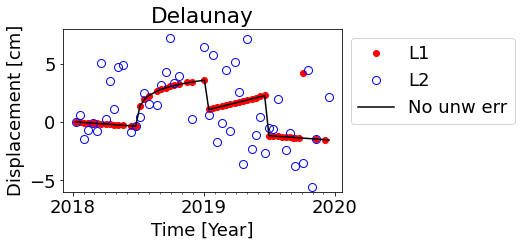

In [17]:
ts_data_l1, ts_data_l2 = invert_timeseries_L1_seasonal(date_list, vpairs_de, vifg_values_de, ref_date_de, 
                               percentage=10, repeat=1, 
                               wavelength=0.056, noise_range=1, sign='random')

plot_unwrap_error(ts_data_l1, ts_data_l2, disp_vol, tbase, name='test_vol_seasonal_L1', title='Delaunay', legend=None, out_dir='./out_figures', ylim = [-6,8])

2 iteration for L1


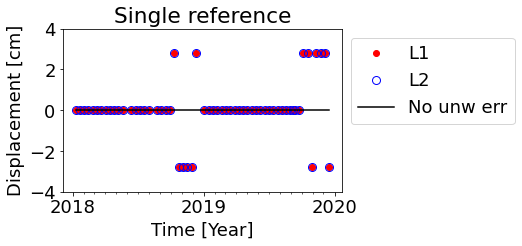

In [1016]:
ts_data_l1, ts_data_l2 = invert_timeseries_L1_seasonal(date_list, pairs_si, ifg_values_si, ref_date_si, 
                               percentage=10, repeat=1, 
                               wavelength=0.056, noise_range=1, sign='random')

plot_unwrap_error(ts_data_l1, ts_data_l2, disp_lin, tbase, name='test_seasonal_L1', title='Single reference', legend=['L1', 'no unwrap err'], out_dir='./out_figures', ylim = [-4,4])

2 iteration for L1


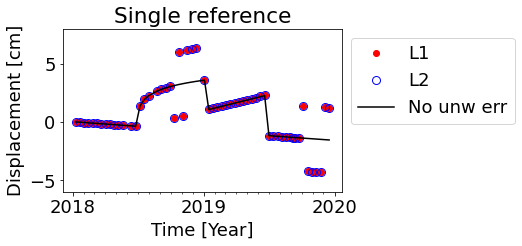

In [1017]:
ts_data_l1, ts_data_l2 = invert_timeseries_L1_seasonal(date_list, vpairs_si, vifg_values_si, ref_date_si, 
                               percentage=10, repeat=1, 
                               wavelength=0.056, noise_range=1, sign='random')

plot_unwrap_error(ts_data_l1, ts_data_l2, disp_vol, tbase, name='test_vol_seasonal_L1', 
                  title='Single reference', legend=['L1', 'no unwrap err'], 
                  out_dir='./out_figures', ylim = [-6,8])

13 iteration for L1


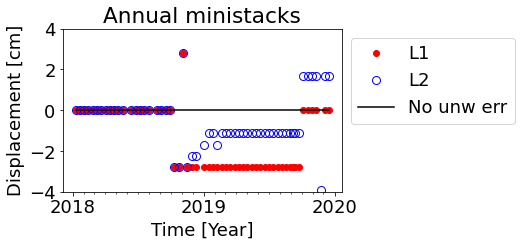

In [1005]:
ts_data_l1, ts_data_l2 = invert_timeseries_L1_seasonal(date_list, pairs_mi, ifg_values_mi, ref_date_mi, 
                               percentage=10, repeat=1, 
                               wavelength=0.056, noise_range=1, sign='random')

plot_unwrap_error(ts_data_l1, ts_data_l2, disp_lin, tbase, name='test_seasonal_L1', title='Annual ministacks', legend=['L1', 'no unwrap err'], out_dir='./out_figures', ylim = [-4,4])

15 iteration for L1


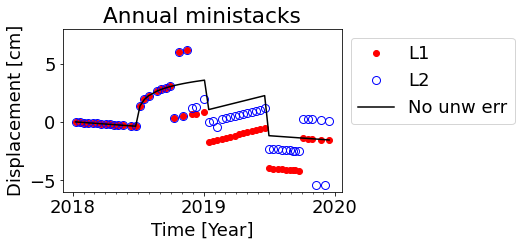

In [997]:
ts_data_l1, ts_data_l2 = invert_timeseries_L1_seasonal(date_list, vpairs_mi, vifg_values_mi, ref_date_mi, 
                               percentage=10, repeat=1, 
                               wavelength=0.056, noise_range=1, sign='random')

plot_unwrap_error(ts_data_l1, ts_data_l2, disp_vol, tbase, 
                  name='test_vol_seasonal_L1', title='Annual ministacks', 
                  legend=['L1', 'no unwrap err'], out_dir='./out_figures', ylim = [-6,8])

56 iteration for L1


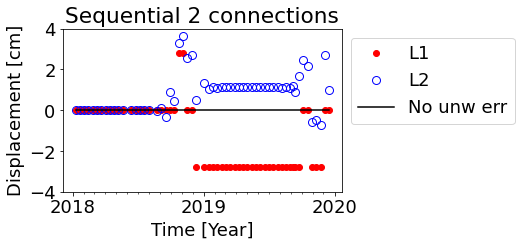

In [998]:
ts_data_l1, ts_data_l2 = invert_timeseries_L1_seasonal(date_list, pairs_se, ifg_values_se, ref_date_se, 
                               percentage=10, repeat=1, 
                               wavelength=0.056, noise_range=1, sign='random')

plot_unwrap_error(ts_data_l1, ts_data_l2, disp_lin, tbase, name='test_seasonal_L1', title='Sequential 2 connections', legend=['L1', 'no unwrap err'], out_dir='./out_figures', ylim = [-4,4])

4 iteration for L1


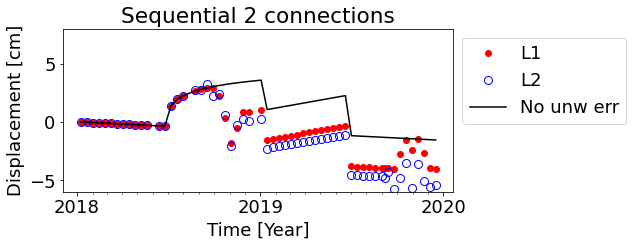

In [796]:
ts_data_l1, ts_data_l2 = invert_timeseries_L1_seasonal(date_list, vpairs_se, vifg_values_se, ref_date_se, 
                               percentage=10, repeat=1, 
                               wavelength=0.056, noise_range=1, sign='random')

plot_unwrap_error(ts_data_l1, ts_data_l2, disp_vol, tbase, name='test_vol_seasonal_L1', title='Sequential 2 connections', legend=['L1', 'no unwrap err'], out_dir='./out_figures', ylim = [-6,8])

5 iteration for L1


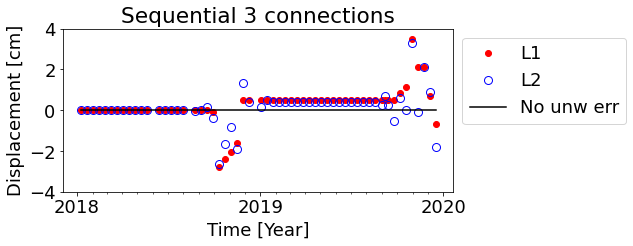

In [797]:
ts_data_l1, ts_data_l2 = invert_timeseries_L1_seasonal(date_list, pairs_se3, ifg_values_se3, ref_date_se3, 
                               percentage=10, repeat=1, 
                               wavelength=0.056, noise_range=1, sign='random')

plot_unwrap_error(ts_data_l1, ts_data_l2, disp_lin, tbase, name='test_seasonal_L1', title='Sequential 3 connections', legend=['L1', 'no unwrap err'], out_dir='./out_figures', ylim = [-4,4])

5 iteration for L1


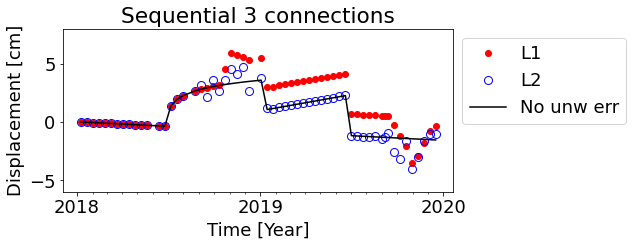

In [798]:
ts_data_l1, ts_data_l2 = invert_timeseries_L1_seasonal(date_list, vpairs_se3, vifg_values_se3, ref_date_se3, 
                               percentage=10, repeat=1, 
                               wavelength=0.056, noise_range=1, sign='random')

plot_unwrap_error(ts_data_l1, ts_data_l2, disp_vol, tbase, name='test_vol_seasonal_L1', title='Sequential 3 connections', legend=['L1', 'no unwrap err'], out_dir='./out_figures',ylim = [-6,8])

5 iteration for L1


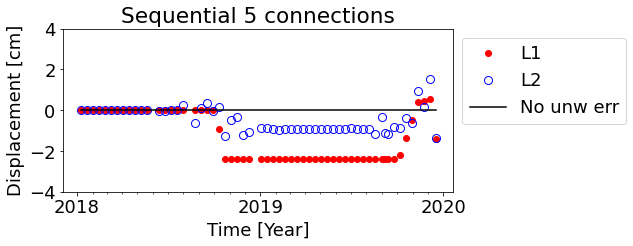

In [799]:
ts_data_l1, ts_data_l2 = invert_timeseries_L1_seasonal(date_list, pairs_se5, ifg_values_se5, ref_date_se5, 
                               percentage=10, repeat=1, 
                               wavelength=0.056, noise_range=1, sign='random')

plot_unwrap_error(ts_data_l1, ts_data_l2, disp_lin, tbase, name='test_seasonal_L1', title='Sequential 5 connections', legend=['L1', 'no unwrap err'], out_dir='./out_figures', ylim = [-4,4])

6 iteration for L1


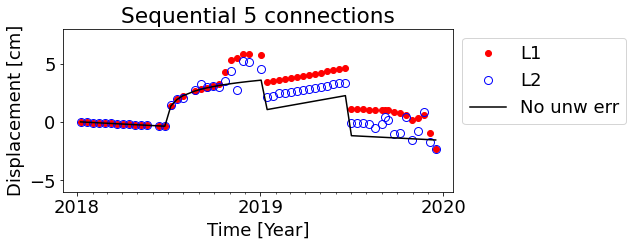

In [800]:
ts_data_l1, ts_data_l2 = invert_timeseries_L1_seasonal(date_list, vpairs_se5, vifg_values_se5, ref_date_se5, 
                               percentage=10, repeat=1, 
                               wavelength=0.056, noise_range=1, sign='random')

plot_unwrap_error(ts_data_l1, ts_data_l2, disp_vol, tbase, name='test_vol_seasonal_L1', title='Sequential 5 connections', legend=['L1', 'no unwrap err'], out_dir='./out_figures', ylim = [-6,8])

5 iteration for L1


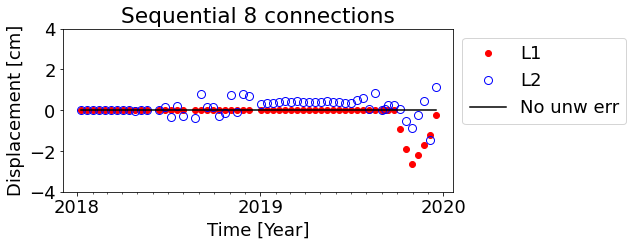

In [801]:
ts_data_l1, ts_data_l2 = invert_timeseries_L1_seasonal(date_list, pairs_se8, ifg_values_se8, ref_date_se8, 
                               percentage=10, repeat=1, 
                               wavelength=0.056, noise_range=1, sign='random')

plot_unwrap_error(ts_data_l1, ts_data_l2, disp_lin, tbase, name='test_seasonal_L1', title='Sequential 8 connections', legend=['L1', 'no unwrap err'], out_dir='./out_figures', ylim = [-4,4])

7 iteration for L1


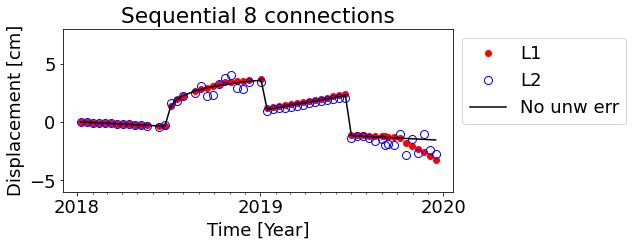

In [802]:
ts_data_l1, ts_data_l2 = invert_timeseries_L1_seasonal(date_list, vpairs_se8, vifg_values_se8, ref_date_se8, 
                               percentage=10, repeat=1, 
                               wavelength=0.056, noise_range=1, sign='random')

plot_unwrap_error(ts_data_l1, ts_data_l2, disp_vol, tbase, name='test_vol_seasonal_L1', title='Sequential 8 connections', legend=['L1', 'no unwrap err'], out_dir='./out_figures', ylim = [-6,8])